In [1]:
%cd ../..

/home/work/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
T=100
dt=1
Boundary=6
signal_noise_ratio = 0.2

In [6]:
def generate_trajectory():
    x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, 1, Boundary)
    STATEs = np.zeros((T+1, 4))
    Disps = np.zeros((T, 2))
    init_state = np.array([x0[0], y0[0], init_v_rand_dir[0, 0], init_v_rand_dir[0, 1]])

    STATEs, Disps, _ = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)
    return STATEs, Disps

In [7]:
import os.path

if os.path.isfile('examples/dynamical_ball/trajectory.data'):
    trajectory_dict = torch.load('examples/dynamical_ball/trajectory.data')
    STATEs = trajectory_dict['STATEs']
    Disps = trajectory_dict['Disps']
else:
    STATEs, Disps = generate_trajectory()
    STATEs = torch.tensor(STATEs, dtype=torch.float32)
    Disps = torch.tensor(Disps, dtype=torch.float32)
    trajectory_dict = {
        'STATEs': STATEs,
        'Disps': Disps,
    }
    torch.save(trajectory_dict, 'examples/dynamical_ball/trajectory.data')

In [8]:
def generate_trajectory_trace():
    trajectory = STATEs
    displacements = Disps

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = point[:2]
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [9]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value.cpu().detach()
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value.cpu().detach()
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value.cpu().detach()
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [10]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [11]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [12]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [13]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [14]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [15]:
def generative_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(bouncing_ball_step, initializer=init_bouncing_ball),
                           lambda: range(T))

In [16]:
def recognition_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return init_bouncing_ball, bouncing_ball_step

In [17]:
def attach_proposals(model, num_particles):
    init_proposal, step_proposal = recognition_model(num_particles)

    init_selector = lambda m: m.name == 'InitBallDynamics'
    init_attach = lambda m: importance.Propose(m, init_proposal)
    model = model.apply(init_attach, init_selector)

    step_selector = lambda m: m.name == 'StepBallDynamics'
    step_attach = lambda m: importance.Propose(m, step_proposal)
    return model.apply(step_attach, step_selector)

In [18]:
def training_model(num_particles, inference_strategy):
    model = generative_model(num_particles)
    model = attach_proposals(model, num_particles)
    return inference_strategy(model)

In [19]:
trajectory, displacements, data = generate_trajectory_trace()

In [20]:
def train_model(num_particles, inference_strategy, inclusive_kl=False, plot_bounds=True, log_estimator=False):
    sampler = training_model(num_particles, inference_strategy)
    
    tau, params, evidence_bounds = importance.variational_importance(
        sampler, 1000, data, use_cuda=True, lr=1e-1,
        inclusive_kl=inclusive_kl, patience=100,
        log_estimator=log_estimator,
    )
    
    if plot_bounds:
        utils.plot_evidence_bounds(evidence_bounds, not inclusive_kl)
    
    return sampler, tau, evidence_bounds

In [21]:
def evaluate_inference(sampler, tau):
    inferred_trajectory = accumulate_trajectory(tau)

    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([tau['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

    graph_original_trajectory(trajectory, T, 0)
    graph_inferred_trajectory(positions, T, 0)
    graph_displacement_trajectories(velocity_steps, displacements, T, 0)
    
    for t in range(T+1):
        logging.info('MSE at time %d: %s' % (t, ((data['position_%d' % t] - positions[t])**2).sum(dim=0)))

In [22]:
sample_sizes = [2, 10, 100]
SAMPLING_STRATEGIES = ['Monte Carlo importance sampling', 'Importance Weighted sampling', 'Sequential Monte Carlo']
sampling_strategies = [(lambda m: m, False), (lambda m: m, True), (lambda m: importance.smc(m), False)]
kl_directions = [False, True]

In [23]:
def experiment():
    results = {}
    for i, (inference_strategy, estimator) in enumerate(sampling_strategies):
        for inclusive_kl in kl_directions:
            for num_particles in sample_sizes:
                logging.info('Experimenting with sampling strategy: ' + SAMPLING_STRATEGIES[i])
                logging.info('Experimenting with sample size of %d', num_particles)
                logging.info('Experimenting with %s training', 'Wake-Sleep' if inclusive_kl else 'Variational')
                sampler, tau, evidence_bounds = train_model((num_particles,), inference_strategy, inclusive_kl, plot_bounds=True, log_estimator=estimator)
                evaluate_inference(sampler, tau)
                results[(SAMPLING_STRATEGIES[i], num_particles, inclusive_kl)] = (tau, evidence_bounds)
    return results

03/03/2019 23:34:19 Experimenting with sampling strategy: Monte Carlo importance sampling
03/03/2019 23:34:19 Experimenting with sample size of 2
03/03/2019 23:34:19 Experimenting with Variational training
03/03/2019 23:34:21 ELBO=-8.26789551e+02 at epoch 1
03/03/2019 23:34:21 ELBO=-5.35450806e+02 at epoch 2
03/03/2019 23:34:22 ELBO=-5.31079834e+02 at epoch 3
03/03/2019 23:34:22 ELBO=-7.11765625e+02 at epoch 4
03/03/2019 23:34:23 ELBO=-1.30174207e+03 at epoch 5
03/03/2019 23:34:23 ELBO=-5.54833008e+02 at epoch 6
03/03/2019 23:34:23 ELBO=-4.40213379e+02 at epoch 7
03/03/2019 23:34:24 ELBO=-5.91195496e+02 at epoch 8
03/03/2019 23:34:24 ELBO=-4.64400513e+02 at epoch 9
03/03/2019 23:34:25 ELBO=-5.66408081e+02 at epoch 10
03/03/2019 23:34:25 ELBO=-4.57884338e+02 at epoch 11
03/03/2019 23:34:25 ELBO=-5.28466003e+02 at epoch 12
03/03/2019 23:34:26 ELBO=-4.39761230e+02 at epoch 13
03/03/2019 23:34:26 ELBO=-4.85170410e+02 at epoch 14
03/03/2019 23:34:27 ELBO=-4.32935669e+02 at epoch 15
03/03/20

Epoch   559: reducing learning rate of group 0 to 5.0000e-02.


03/03/2019 23:38:18 ELBO=-1.42036942e+02 at epoch 561
03/03/2019 23:38:19 ELBO=-1.19252350e+02 at epoch 562
03/03/2019 23:38:19 ELBO=-1.43296753e+02 at epoch 563
03/03/2019 23:38:19 ELBO=-1.22771393e+02 at epoch 564
03/03/2019 23:38:20 ELBO=-1.16927673e+02 at epoch 565
03/03/2019 23:38:20 ELBO=-1.23996262e+02 at epoch 566
03/03/2019 23:38:21 ELBO=-1.35340973e+02 at epoch 567
03/03/2019 23:38:21 ELBO=-1.23624092e+02 at epoch 568
03/03/2019 23:38:22 ELBO=-1.26844872e+02 at epoch 569
03/03/2019 23:38:22 ELBO=-1.22480835e+02 at epoch 570
03/03/2019 23:38:22 ELBO=-1.28602005e+02 at epoch 571
03/03/2019 23:38:23 ELBO=-1.16109009e+02 at epoch 572
03/03/2019 23:38:23 ELBO=-1.18948624e+02 at epoch 573
03/03/2019 23:38:24 ELBO=-1.31610519e+02 at epoch 574
03/03/2019 23:38:24 ELBO=-1.16352333e+02 at epoch 575
03/03/2019 23:38:24 ELBO=-1.28370010e+02 at epoch 576
03/03/2019 23:38:25 ELBO=-1.37125641e+02 at epoch 577
03/03/2019 23:38:25 ELBO=-1.25814346e+02 at epoch 578
03/03/2019 23:38:26 ELBO=-1.

Epoch   779: reducing learning rate of group 0 to 2.5000e-02.


03/03/2019 23:39:49 ELBO=-1.25450348e+02 at epoch 781
03/03/2019 23:39:49 ELBO=-1.09666245e+02 at epoch 782
03/03/2019 23:39:50 ELBO=-1.17220978e+02 at epoch 783
03/03/2019 23:39:50 ELBO=-1.28433380e+02 at epoch 784
03/03/2019 23:39:51 ELBO=-1.06470551e+02 at epoch 785
03/03/2019 23:39:51 ELBO=-1.07916313e+02 at epoch 786
03/03/2019 23:39:51 ELBO=-1.16963974e+02 at epoch 787
03/03/2019 23:39:52 ELBO=-1.00989548e+02 at epoch 788
03/03/2019 23:39:52 ELBO=-1.18795486e+02 at epoch 789
03/03/2019 23:39:53 ELBO=-1.03581940e+02 at epoch 790
03/03/2019 23:39:53 ELBO=-9.94313507e+01 at epoch 791
03/03/2019 23:39:54 ELBO=-1.07896988e+02 at epoch 792
03/03/2019 23:39:54 ELBO=-1.23112556e+02 at epoch 793
03/03/2019 23:39:54 ELBO=-1.12735809e+02 at epoch 794
03/03/2019 23:39:55 ELBO=-1.16123489e+02 at epoch 795
03/03/2019 23:39:55 ELBO=-1.14467125e+02 at epoch 796
03/03/2019 23:39:56 ELBO=-1.07565063e+02 at epoch 797
03/03/2019 23:39:56 ELBO=-1.09223831e+02 at epoch 798
03/03/2019 23:39:56 ELBO=-9.

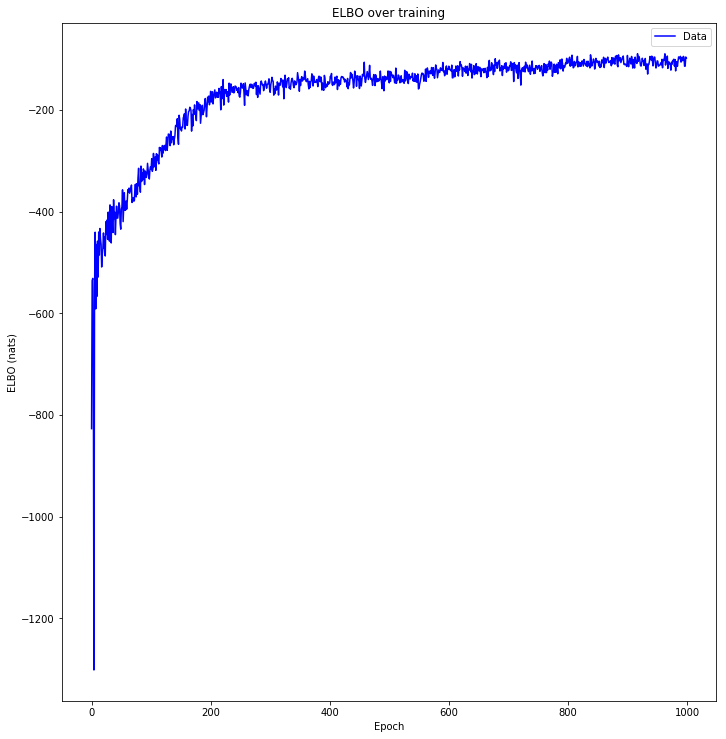

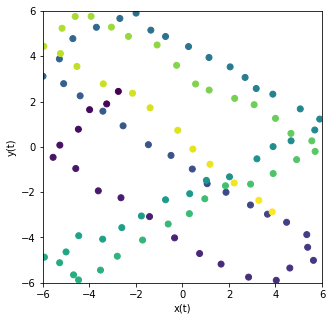

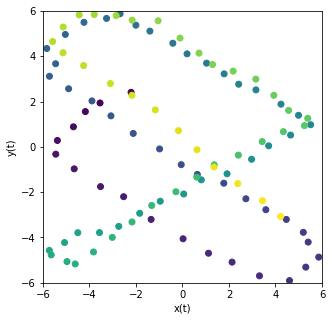

03/03/2019 23:41:23 MSE at time 0: tensor(0.3017)
03/03/2019 23:41:23 MSE at time 1: tensor(0.0833)
03/03/2019 23:41:23 MSE at time 2: tensor(0.0405)
03/03/2019 23:41:23 MSE at time 3: tensor(0.0563)
03/03/2019 23:41:23 MSE at time 4: tensor(0.0532)
03/03/2019 23:41:23 MSE at time 5: tensor(0.0324)
03/03/2019 23:41:23 MSE at time 6: tensor(0.0047)
03/03/2019 23:41:23 MSE at time 7: tensor(0.0434)
03/03/2019 23:41:23 MSE at time 8: tensor(0.0152)
03/03/2019 23:41:23 MSE at time 9: tensor(0.0200)
03/03/2019 23:41:23 MSE at time 10: tensor(0.1353)
03/03/2019 23:41:23 MSE at time 11: tensor(0.1474)
03/03/2019 23:41:23 MSE at time 12: tensor(0.2313)
03/03/2019 23:41:23 MSE at time 13: tensor(0.2230)
03/03/2019 23:41:23 MSE at time 14: tensor(0.3238)
03/03/2019 23:41:23 MSE at time 15: tensor(0.4726)
03/03/2019 23:41:23 MSE at time 16: tensor(0.0722)
03/03/2019 23:41:23 MSE at time 17: tensor(0.0526)
03/03/2019 23:41:23 MSE at time 18: tensor(0.0322)
03/03/2019 23:41:23 MSE at time 19: tenso

Epoch   843: reducing learning rate of group 0 to 5.0000e-02.


03/03/2019 23:47:19 ELBO=-1.04568260e+02 at epoch 845
03/03/2019 23:47:20 ELBO=-1.03375572e+02 at epoch 846
03/03/2019 23:47:20 ELBO=-1.02534447e+02 at epoch 847
03/03/2019 23:47:20 ELBO=-9.71054611e+01 at epoch 848
03/03/2019 23:47:21 ELBO=-9.84442368e+01 at epoch 849
03/03/2019 23:47:21 ELBO=-9.84333725e+01 at epoch 850
03/03/2019 23:47:22 ELBO=-9.81657257e+01 at epoch 851
03/03/2019 23:47:22 ELBO=-1.01133202e+02 at epoch 852
03/03/2019 23:47:23 ELBO=-1.03078331e+02 at epoch 853
03/03/2019 23:47:23 ELBO=-1.06747437e+02 at epoch 854
03/03/2019 23:47:24 ELBO=-1.10437622e+02 at epoch 855
03/03/2019 23:47:24 ELBO=-1.01429024e+02 at epoch 856
03/03/2019 23:47:24 ELBO=-9.81406021e+01 at epoch 857
03/03/2019 23:47:25 ELBO=-9.56862106e+01 at epoch 858
03/03/2019 23:47:25 ELBO=-9.02866821e+01 at epoch 859
03/03/2019 23:47:26 ELBO=-8.89898682e+01 at epoch 860
03/03/2019 23:47:26 ELBO=-9.15263824e+01 at epoch 861
03/03/2019 23:47:26 ELBO=-9.49141541e+01 at epoch 862
03/03/2019 23:47:27 ELBO=-9.

Epoch   995: reducing learning rate of group 0 to 2.5000e-02.


03/03/2019 23:48:23 ELBO=-9.44686203e+01 at epoch 997
03/03/2019 23:48:24 ELBO=-1.01612259e+02 at epoch 998
03/03/2019 23:48:24 ELBO=-1.00284599e+02 at epoch 999
03/03/2019 23:48:24 ELBO=-9.87745361e+01 at epoch 1000


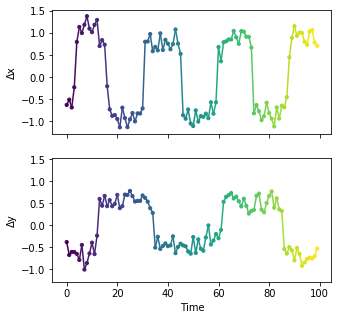

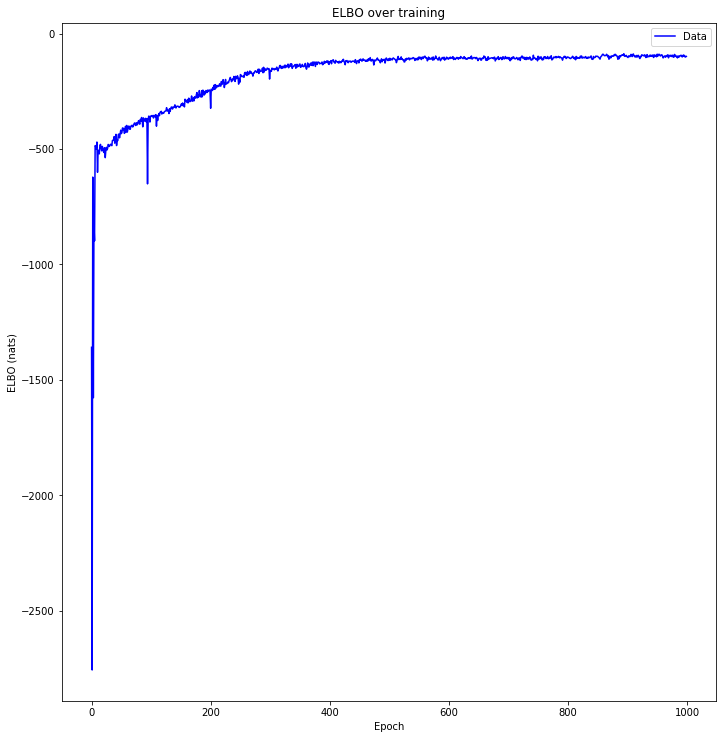

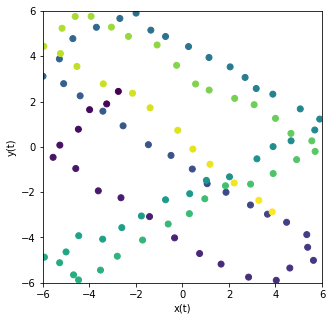

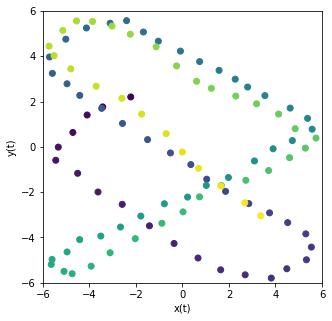

03/03/2019 23:48:25 MSE at time 0: tensor(0.3438)
03/03/2019 23:48:25 MSE at time 1: tensor(0.0464)
03/03/2019 23:48:25 MSE at time 2: tensor(0.0667)
03/03/2019 23:48:25 MSE at time 3: tensor(0.0765)
03/03/2019 23:48:25 MSE at time 4: tensor(0.0121)
03/03/2019 23:48:25 MSE at time 5: tensor(0.0299)
03/03/2019 23:48:25 MSE at time 6: tensor(0.0510)
03/03/2019 23:48:25 MSE at time 7: tensor(0.0029)
03/03/2019 23:48:25 MSE at time 8: tensor(0.0885)
03/03/2019 23:48:25 MSE at time 9: tensor(0.1654)
03/03/2019 23:48:25 MSE at time 10: tensor(0.0620)
03/03/2019 23:48:25 MSE at time 11: tensor(0.0439)
03/03/2019 23:48:25 MSE at time 12: tensor(0.0645)
03/03/2019 23:48:25 MSE at time 13: tensor(0.0319)
03/03/2019 23:48:25 MSE at time 14: tensor(0.0560)
03/03/2019 23:48:25 MSE at time 15: tensor(0.0177)
03/03/2019 23:48:25 MSE at time 16: tensor(0.0911)
03/03/2019 23:48:25 MSE at time 17: tensor(0.0258)
03/03/2019 23:48:25 MSE at time 18: tensor(0.0029)
03/03/2019 23:48:25 MSE at time 19: tenso

Epoch   488: reducing learning rate of group 0 to 5.0000e-02.


03/03/2019 23:52:08 ELBO=-9.17613297e+01 at epoch 490
03/03/2019 23:52:09 ELBO=-9.05589981e+01 at epoch 491
03/03/2019 23:52:09 ELBO=-9.11064606e+01 at epoch 492
03/03/2019 23:52:10 ELBO=-9.01291580e+01 at epoch 493
03/03/2019 23:52:10 ELBO=-9.29217529e+01 at epoch 494
03/03/2019 23:52:11 ELBO=-9.51667786e+01 at epoch 495
03/03/2019 23:52:11 ELBO=-9.23837509e+01 at epoch 496
03/03/2019 23:52:12 ELBO=-9.11913223e+01 at epoch 497
03/03/2019 23:52:12 ELBO=-9.14722137e+01 at epoch 498
03/03/2019 23:52:12 ELBO=-9.10375366e+01 at epoch 499
03/03/2019 23:52:13 ELBO=-9.07579727e+01 at epoch 500
03/03/2019 23:52:13 ELBO=-8.96751556e+01 at epoch 501
03/03/2019 23:52:14 ELBO=-8.99001160e+01 at epoch 502
03/03/2019 23:52:14 ELBO=-9.24132996e+01 at epoch 503
03/03/2019 23:52:15 ELBO=-9.27485123e+01 at epoch 504
03/03/2019 23:52:15 ELBO=-9.18530655e+01 at epoch 505
03/03/2019 23:52:16 ELBO=-9.21872253e+01 at epoch 506
03/03/2019 23:52:16 ELBO=-9.09980469e+01 at epoch 507
03/03/2019 23:52:17 ELBO=-9.

Epoch   741: reducing learning rate of group 0 to 2.5000e-02.


03/03/2019 23:54:04 ELBO=-9.12089539e+01 at epoch 743
03/03/2019 23:54:04 ELBO=-9.15446625e+01 at epoch 744
03/03/2019 23:54:05 ELBO=-9.18301849e+01 at epoch 745
03/03/2019 23:54:05 ELBO=-9.05239258e+01 at epoch 746
03/03/2019 23:54:06 ELBO=-9.19490509e+01 at epoch 747
03/03/2019 23:54:06 ELBO=-9.08632202e+01 at epoch 748
03/03/2019 23:54:07 ELBO=-8.94457016e+01 at epoch 749
03/03/2019 23:54:07 ELBO=-9.05861588e+01 at epoch 750
03/03/2019 23:54:07 ELBO=-8.91001358e+01 at epoch 751
03/03/2019 23:54:08 ELBO=-9.05223007e+01 at epoch 752
03/03/2019 23:54:08 ELBO=-9.07207336e+01 at epoch 753
03/03/2019 23:54:09 ELBO=-9.07286148e+01 at epoch 754
03/03/2019 23:54:09 ELBO=-9.18215714e+01 at epoch 755
03/03/2019 23:54:10 ELBO=-9.14251709e+01 at epoch 756
03/03/2019 23:54:10 ELBO=-9.08185349e+01 at epoch 757
03/03/2019 23:54:11 ELBO=-8.99339142e+01 at epoch 758
03/03/2019 23:54:11 ELBO=-9.13381500e+01 at epoch 759
03/03/2019 23:54:11 ELBO=-8.96027679e+01 at epoch 760
03/03/2019 23:54:12 ELBO=-9.

Epoch   888: reducing learning rate of group 0 to 1.2500e-02.


03/03/2019 23:55:10 ELBO=-9.11900787e+01 at epoch 890
03/03/2019 23:55:11 ELBO=-9.03839417e+01 at epoch 891
03/03/2019 23:55:11 ELBO=-9.15479660e+01 at epoch 892
03/03/2019 23:55:12 ELBO=-8.96089020e+01 at epoch 893
03/03/2019 23:55:12 ELBO=-8.98694916e+01 at epoch 894
03/03/2019 23:55:13 ELBO=-9.04485931e+01 at epoch 895
03/03/2019 23:55:13 ELBO=-9.05944138e+01 at epoch 896
03/03/2019 23:55:14 ELBO=-8.87354050e+01 at epoch 897
03/03/2019 23:55:14 ELBO=-8.87004471e+01 at epoch 898
03/03/2019 23:55:15 ELBO=-9.21178131e+01 at epoch 899
03/03/2019 23:55:15 ELBO=-9.33658218e+01 at epoch 900
03/03/2019 23:55:16 ELBO=-9.05973969e+01 at epoch 901
03/03/2019 23:55:16 ELBO=-9.09293137e+01 at epoch 902
03/03/2019 23:55:16 ELBO=-8.94783401e+01 at epoch 903
03/03/2019 23:55:17 ELBO=-9.06013260e+01 at epoch 904
03/03/2019 23:55:17 ELBO=-8.99919891e+01 at epoch 905
03/03/2019 23:55:18 ELBO=-8.92414246e+01 at epoch 906
03/03/2019 23:55:18 ELBO=-9.18059921e+01 at epoch 907
03/03/2019 23:55:19 ELBO=-9.

Epoch   989: reducing learning rate of group 0 to 6.2500e-03.


03/03/2019 23:55:56 ELBO=-9.11980286e+01 at epoch 991
03/03/2019 23:55:57 ELBO=-9.14186172e+01 at epoch 992
03/03/2019 23:55:57 ELBO=-9.11422958e+01 at epoch 993
03/03/2019 23:55:57 ELBO=-8.93737640e+01 at epoch 994
03/03/2019 23:55:58 ELBO=-8.97571335e+01 at epoch 995
03/03/2019 23:55:58 ELBO=-8.92853317e+01 at epoch 996
03/03/2019 23:55:59 ELBO=-9.29677505e+01 at epoch 997
03/03/2019 23:55:59 ELBO=-8.91750565e+01 at epoch 998
03/03/2019 23:56:00 ELBO=-9.00051575e+01 at epoch 999
03/03/2019 23:56:00 ELBO=-9.12373428e+01 at epoch 1000


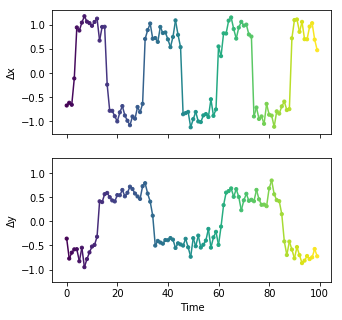

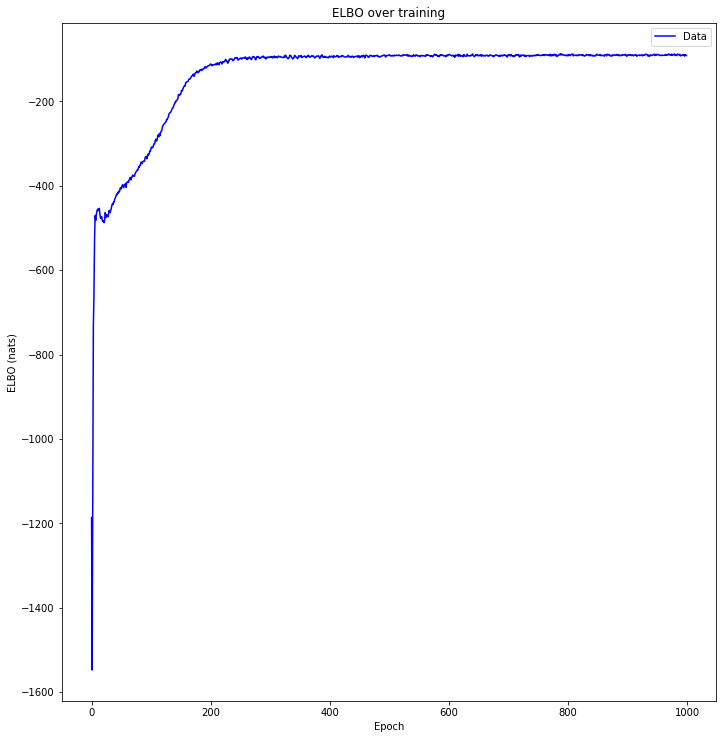

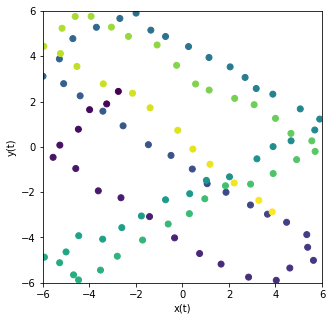

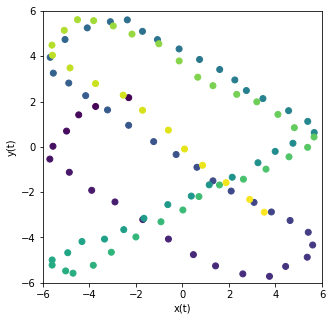

03/03/2019 23:56:01 MSE at time 0: tensor(0.2755)
03/03/2019 23:56:01 MSE at time 1: tensor(0.2393)
03/03/2019 23:56:01 MSE at time 2: tensor(0.2718)
03/03/2019 23:56:01 MSE at time 3: tensor(0.2657)
03/03/2019 23:56:01 MSE at time 4: tensor(0.0901)
03/03/2019 23:56:01 MSE at time 5: tensor(0.0259)
03/03/2019 23:56:01 MSE at time 6: tensor(0.1049)
03/03/2019 23:56:01 MSE at time 7: tensor(0.0812)
03/03/2019 23:56:01 MSE at time 8: tensor(0.1010)
03/03/2019 23:56:01 MSE at time 9: tensor(0.1021)
03/03/2019 23:56:01 MSE at time 10: tensor(0.0728)
03/03/2019 23:56:01 MSE at time 11: tensor(0.0732)
03/03/2019 23:56:01 MSE at time 12: tensor(0.0623)
03/03/2019 23:56:01 MSE at time 13: tensor(0.0818)
03/03/2019 23:56:01 MSE at time 14: tensor(0.1163)
03/03/2019 23:56:01 MSE at time 15: tensor(0.0374)
03/03/2019 23:56:01 MSE at time 16: tensor(0.0906)
03/03/2019 23:56:01 MSE at time 17: tensor(0.0566)
03/03/2019 23:56:01 MSE at time 18: tensor(0.0144)
03/03/2019 23:56:01 MSE at time 19: tenso

Epoch   544: reducing learning rate of group 0 to 5.0000e-02.


03/03/2019 23:59:49 EUBO=1.42962738e+02 at epoch 546
03/03/2019 23:59:49 EUBO=1.48350296e+02 at epoch 547
03/03/2019 23:59:50 EUBO=1.49259644e+02 at epoch 548
03/03/2019 23:59:50 EUBO=1.44142899e+02 at epoch 549
03/03/2019 23:59:50 EUBO=1.36439178e+02 at epoch 550
03/03/2019 23:59:51 EUBO=1.51148636e+02 at epoch 551
03/03/2019 23:59:51 EUBO=1.51079407e+02 at epoch 552
03/03/2019 23:59:52 EUBO=1.18784286e+02 at epoch 553
03/03/2019 23:59:52 EUBO=1.44278473e+02 at epoch 554
03/03/2019 23:59:52 EUBO=1.34077713e+02 at epoch 555
03/03/2019 23:59:53 EUBO=1.36750412e+02 at epoch 556
03/03/2019 23:59:53 EUBO=1.16759537e+02 at epoch 557
03/03/2019 23:59:54 EUBO=1.33769928e+02 at epoch 558
03/03/2019 23:59:54 EUBO=1.17068176e+02 at epoch 559
03/03/2019 23:59:55 EUBO=1.31203094e+02 at epoch 560
03/03/2019 23:59:55 EUBO=1.20179901e+02 at epoch 561
03/03/2019 23:59:55 EUBO=1.27750420e+02 at epoch 562
03/03/2019 23:59:56 EUBO=1.40873657e+02 at epoch 563
03/03/2019 23:59:56 EUBO=1.32801758e+02 at epo

Epoch   766: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 00:01:27 EUBO=1.20416435e+02 at epoch 768
03/04/2019 00:01:28 EUBO=1.02486664e+02 at epoch 769
03/04/2019 00:01:28 EUBO=1.04714005e+02 at epoch 770
03/04/2019 00:01:28 EUBO=1.03543221e+02 at epoch 771
03/04/2019 00:01:29 EUBO=1.15048050e+02 at epoch 772
03/04/2019 00:01:29 EUBO=1.14195770e+02 at epoch 773
03/04/2019 00:01:30 EUBO=1.01753677e+02 at epoch 774
03/04/2019 00:01:30 EUBO=1.09683823e+02 at epoch 775
03/04/2019 00:01:31 EUBO=9.13845367e+01 at epoch 776
03/04/2019 00:01:31 EUBO=1.27243401e+02 at epoch 777
03/04/2019 00:01:31 EUBO=1.24994232e+02 at epoch 778
03/04/2019 00:01:32 EUBO=1.04298126e+02 at epoch 779
03/04/2019 00:01:32 EUBO=9.74864197e+01 at epoch 780
03/04/2019 00:01:33 EUBO=1.09761055e+02 at epoch 781
03/04/2019 00:01:33 EUBO=1.06594101e+02 at epoch 782
03/04/2019 00:01:33 EUBO=1.14722984e+02 at epoch 783
03/04/2019 00:01:34 EUBO=1.04490860e+02 at epoch 784
03/04/2019 00:01:34 EUBO=1.13958183e+02 at epoch 785
03/04/2019 00:01:35 EUBO=1.17291489e+02 at epo

Epoch   944: reducing learning rate of group 0 to 1.2500e-02.


03/04/2019 00:02:41 EUBO=9.81925201e+01 at epoch 946
03/04/2019 00:02:42 EUBO=9.96107330e+01 at epoch 947
03/04/2019 00:02:42 EUBO=1.04005920e+02 at epoch 948
03/04/2019 00:02:46 EUBO=9.39102707e+01 at epoch 949
03/04/2019 00:02:46 EUBO=1.06305656e+02 at epoch 950
03/04/2019 00:02:47 EUBO=1.28004944e+02 at epoch 951
03/04/2019 00:02:47 EUBO=8.24825439e+01 at epoch 952
03/04/2019 00:02:48 EUBO=9.02885895e+01 at epoch 953
03/04/2019 00:02:48 EUBO=9.99027023e+01 at epoch 954
03/04/2019 00:02:49 EUBO=9.99813690e+01 at epoch 955
03/04/2019 00:02:49 EUBO=9.47751694e+01 at epoch 956
03/04/2019 00:02:50 EUBO=1.02421082e+02 at epoch 957
03/04/2019 00:02:50 EUBO=1.02390457e+02 at epoch 958
03/04/2019 00:02:50 EUBO=9.06925964e+01 at epoch 959
03/04/2019 00:02:51 EUBO=1.02859451e+02 at epoch 960
03/04/2019 00:02:51 EUBO=9.39093857e+01 at epoch 961
03/04/2019 00:02:52 EUBO=9.97209778e+01 at epoch 962
03/04/2019 00:02:52 EUBO=9.63515549e+01 at epoch 963
03/04/2019 00:02:53 EUBO=1.14617119e+02 at epo

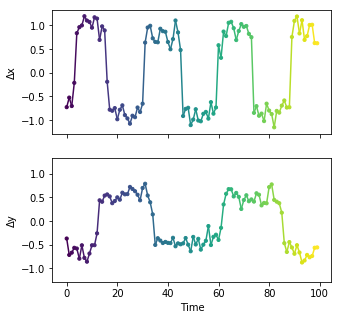

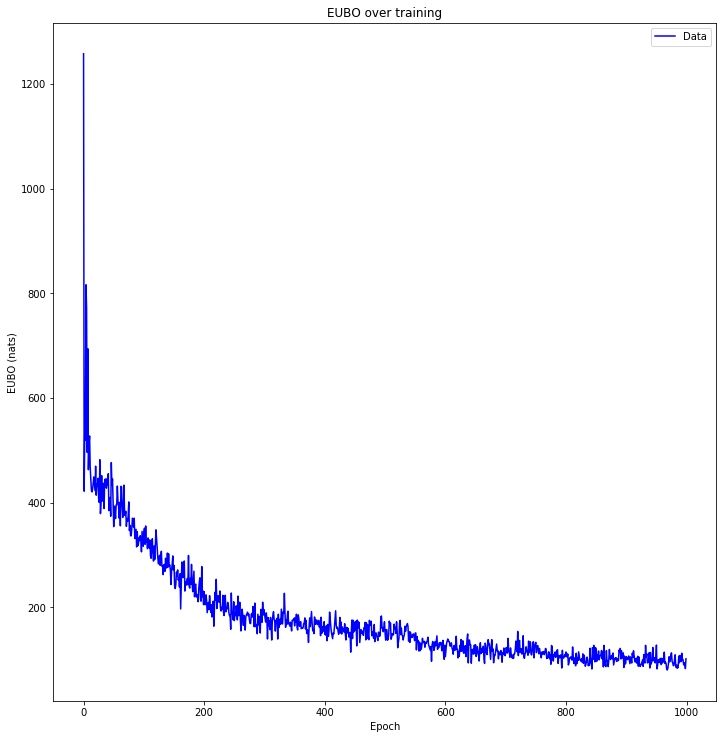

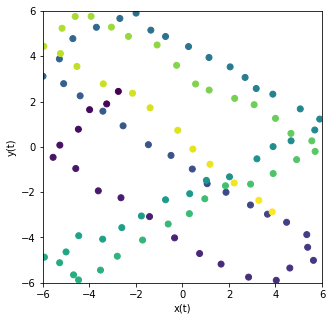

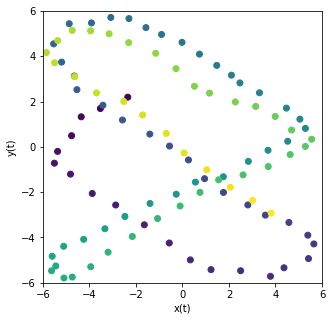

03/04/2019 00:03:12 MSE at time 0: tensor(0.2292)
03/04/2019 00:03:12 MSE at time 1: tensor(0.1143)
03/04/2019 00:03:12 MSE at time 2: tensor(0.2287)
03/04/2019 00:03:12 MSE at time 3: tensor(0.1673)
03/04/2019 00:03:12 MSE at time 4: tensor(0.0856)
03/04/2019 00:03:12 MSE at time 5: tensor(0.0701)
03/04/2019 00:03:12 MSE at time 6: tensor(0.1136)
03/04/2019 00:03:12 MSE at time 7: tensor(0.0819)
03/04/2019 00:03:12 MSE at time 8: tensor(0.1553)
03/04/2019 00:03:12 MSE at time 9: tensor(0.1814)
03/04/2019 00:03:12 MSE at time 10: tensor(0.1037)
03/04/2019 00:03:12 MSE at time 11: tensor(0.2371)
03/04/2019 00:03:12 MSE at time 12: tensor(0.2464)
03/04/2019 00:03:12 MSE at time 13: tensor(0.1967)
03/04/2019 00:03:12 MSE at time 14: tensor(0.0936)
03/04/2019 00:03:12 MSE at time 15: tensor(0.0627)
03/04/2019 00:03:12 MSE at time 16: tensor(0.0510)
03/04/2019 00:03:12 MSE at time 17: tensor(0.0926)
03/04/2019 00:03:12 MSE at time 18: tensor(0.0027)
03/04/2019 00:03:12 MSE at time 19: tenso

Epoch   448: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 00:06:21 EUBO=1.65750687e+02 at epoch 450
03/04/2019 00:06:21 EUBO=1.44237839e+02 at epoch 451
03/04/2019 00:06:21 EUBO=1.24152771e+02 at epoch 452
03/04/2019 00:06:22 EUBO=1.41386993e+02 at epoch 453
03/04/2019 00:06:22 EUBO=1.40847000e+02 at epoch 454
03/04/2019 00:06:23 EUBO=1.43166611e+02 at epoch 455
03/04/2019 00:06:23 EUBO=1.34670975e+02 at epoch 456
03/04/2019 00:06:24 EUBO=1.45776352e+02 at epoch 457
03/04/2019 00:06:24 EUBO=1.22979301e+02 at epoch 458
03/04/2019 00:06:25 EUBO=1.23944603e+02 at epoch 459
03/04/2019 00:06:25 EUBO=1.06158180e+02 at epoch 460
03/04/2019 00:06:25 EUBO=1.27105080e+02 at epoch 461
03/04/2019 00:06:26 EUBO=1.27883720e+02 at epoch 462
03/04/2019 00:06:26 EUBO=1.01938141e+02 at epoch 463
03/04/2019 00:06:27 EUBO=1.14679626e+02 at epoch 464
03/04/2019 00:06:27 EUBO=1.09623924e+02 at epoch 465
03/04/2019 00:06:28 EUBO=1.00102364e+02 at epoch 466
03/04/2019 00:06:28 EUBO=1.32719391e+02 at epoch 467
03/04/2019 00:06:29 EUBO=1.10169945e+02 at epo

Epoch   690: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 00:08:01 EUBO=1.12227295e+02 at epoch 692
03/04/2019 00:08:02 EUBO=1.28033371e+02 at epoch 693
03/04/2019 00:08:02 EUBO=1.02382202e+02 at epoch 694
03/04/2019 00:08:02 EUBO=1.12071709e+02 at epoch 695
03/04/2019 00:08:03 EUBO=1.12444656e+02 at epoch 696
03/04/2019 00:08:03 EUBO=1.04095390e+02 at epoch 697
03/04/2019 00:08:04 EUBO=9.43225021e+01 at epoch 698
03/04/2019 00:08:04 EUBO=1.01703629e+02 at epoch 699
03/04/2019 00:08:05 EUBO=1.10285843e+02 at epoch 700
03/04/2019 00:08:05 EUBO=1.11713188e+02 at epoch 701
03/04/2019 00:08:05 EUBO=8.93157578e+01 at epoch 702
03/04/2019 00:08:06 EUBO=1.05848442e+02 at epoch 703
03/04/2019 00:08:06 EUBO=1.05192848e+02 at epoch 704
03/04/2019 00:08:07 EUBO=1.07431816e+02 at epoch 705
03/04/2019 00:08:07 EUBO=9.69055328e+01 at epoch 706
03/04/2019 00:08:07 EUBO=1.01851074e+02 at epoch 707
03/04/2019 00:08:08 EUBO=9.72125320e+01 at epoch 708
03/04/2019 00:08:08 EUBO=1.06079765e+02 at epoch 709
03/04/2019 00:08:09 EUBO=9.25510483e+01 at epo

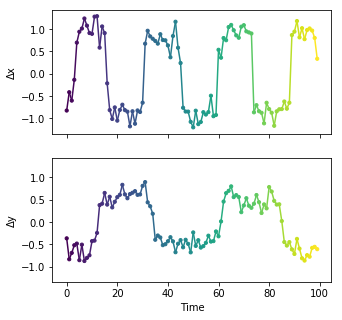

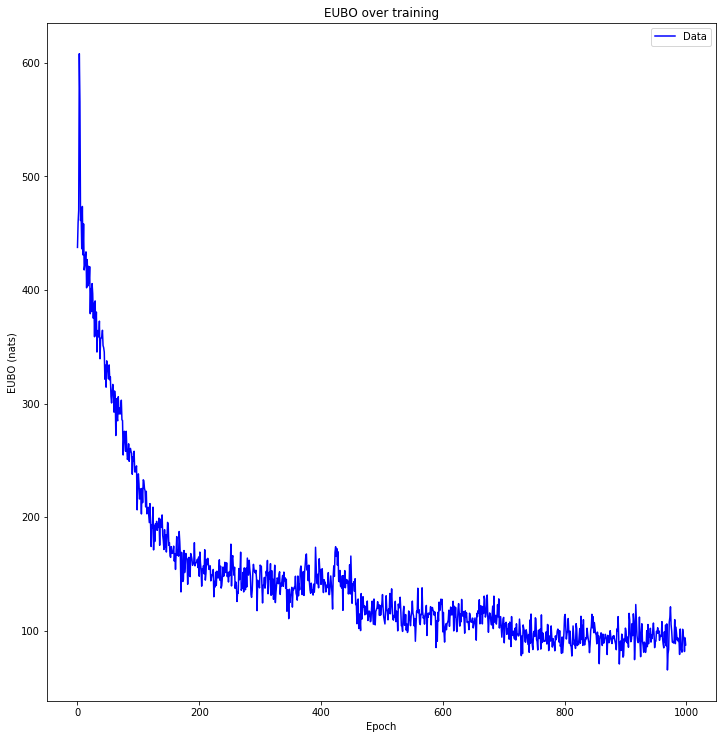

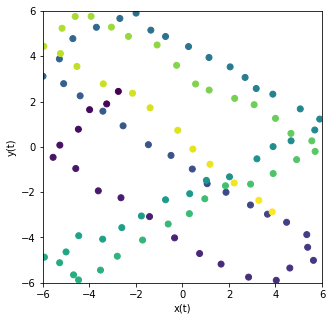

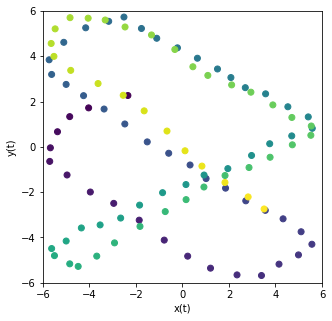

03/04/2019 00:10:17 MSE at time 0: tensor(0.2014)
03/04/2019 00:10:17 MSE at time 1: tensor(0.6339)
03/04/2019 00:10:17 MSE at time 2: tensor(0.8259)
03/04/2019 00:10:17 MSE at time 3: tensor(0.8191)
03/04/2019 00:10:17 MSE at time 4: tensor(0.1797)
03/04/2019 00:10:17 MSE at time 5: tensor(0.0534)
03/04/2019 00:10:17 MSE at time 6: tensor(0.2222)
03/04/2019 00:10:17 MSE at time 7: tensor(0.1206)
03/04/2019 00:10:17 MSE at time 8: tensor(0.1588)
03/04/2019 00:10:17 MSE at time 9: tensor(0.2218)
03/04/2019 00:10:17 MSE at time 10: tensor(0.2075)
03/04/2019 00:10:17 MSE at time 11: tensor(0.2763)
03/04/2019 00:10:17 MSE at time 12: tensor(0.2383)
03/04/2019 00:10:17 MSE at time 13: tensor(0.2568)
03/04/2019 00:10:17 MSE at time 14: tensor(0.4493)
03/04/2019 00:10:17 MSE at time 15: tensor(0.2452)
03/04/2019 00:10:17 MSE at time 16: tensor(0.4726)
03/04/2019 00:10:17 MSE at time 17: tensor(0.0512)
03/04/2019 00:10:17 MSE at time 18: tensor(0.0756)
03/04/2019 00:10:17 MSE at time 19: tenso

Epoch   258: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 00:12:35 EUBO=1.57065292e+02 at epoch 260
03/04/2019 00:12:35 EUBO=1.32535751e+02 at epoch 261
03/04/2019 00:12:36 EUBO=1.41421402e+02 at epoch 262
03/04/2019 00:12:36 EUBO=1.30766205e+02 at epoch 263
03/04/2019 00:12:37 EUBO=1.33754669e+02 at epoch 264
03/04/2019 00:12:37 EUBO=1.20807617e+02 at epoch 265
03/04/2019 00:12:38 EUBO=1.25912560e+02 at epoch 266
03/04/2019 00:12:38 EUBO=1.21031952e+02 at epoch 267
03/04/2019 00:12:39 EUBO=1.17314682e+02 at epoch 268
03/04/2019 00:12:39 EUBO=1.23548027e+02 at epoch 269
03/04/2019 00:12:40 EUBO=1.22610527e+02 at epoch 270
03/04/2019 00:12:40 EUBO=1.17866234e+02 at epoch 271
03/04/2019 00:12:41 EUBO=1.04185135e+02 at epoch 272
03/04/2019 00:12:41 EUBO=1.02841934e+02 at epoch 273
03/04/2019 00:12:42 EUBO=1.11298668e+02 at epoch 274
03/04/2019 00:12:42 EUBO=1.18831970e+02 at epoch 275
03/04/2019 00:12:43 EUBO=1.23435486e+02 at epoch 276
03/04/2019 00:12:43 EUBO=1.14369400e+02 at epoch 277
03/04/2019 00:12:44 EUBO=1.20492752e+02 at epo

Epoch   393: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 00:13:40 EUBO=1.10187431e+02 at epoch 395
03/04/2019 00:13:41 EUBO=1.17247383e+02 at epoch 396
03/04/2019 00:13:41 EUBO=1.11154175e+02 at epoch 397
03/04/2019 00:13:42 EUBO=1.09200981e+02 at epoch 398
03/04/2019 00:13:42 EUBO=1.13742172e+02 at epoch 399
03/04/2019 00:13:43 EUBO=1.11642715e+02 at epoch 400
03/04/2019 00:13:43 EUBO=1.02522743e+02 at epoch 401
03/04/2019 00:13:44 EUBO=1.11151505e+02 at epoch 402
03/04/2019 00:13:44 EUBO=1.10105331e+02 at epoch 403
03/04/2019 00:13:45 EUBO=9.89636536e+01 at epoch 404
03/04/2019 00:13:45 EUBO=1.07722847e+02 at epoch 405
03/04/2019 00:13:46 EUBO=1.05289902e+02 at epoch 406
03/04/2019 00:13:46 EUBO=8.21879120e+01 at epoch 407
03/04/2019 00:13:47 EUBO=1.01487488e+02 at epoch 408
03/04/2019 00:13:47 EUBO=9.42315445e+01 at epoch 409
03/04/2019 00:13:48 EUBO=1.02138222e+02 at epoch 410
03/04/2019 00:13:48 EUBO=9.47946625e+01 at epoch 411
03/04/2019 00:13:49 EUBO=9.72165833e+01 at epoch 412
03/04/2019 00:13:49 EUBO=1.01829689e+02 at epo

Epoch   623: reducing learning rate of group 0 to 1.2500e-02.


03/04/2019 00:15:30 EUBO=9.83504257e+01 at epoch 625
03/04/2019 00:15:31 EUBO=8.72683182e+01 at epoch 626
03/04/2019 00:15:31 EUBO=8.96999207e+01 at epoch 627
03/04/2019 00:15:32 EUBO=9.37486572e+01 at epoch 628
03/04/2019 00:15:32 EUBO=9.28804016e+01 at epoch 629
03/04/2019 00:15:33 EUBO=8.99636765e+01 at epoch 630
03/04/2019 00:15:33 EUBO=7.22096100e+01 at epoch 631
03/04/2019 00:15:34 EUBO=8.34963379e+01 at epoch 632
03/04/2019 00:15:34 EUBO=7.81388931e+01 at epoch 633
03/04/2019 00:15:35 EUBO=8.36009064e+01 at epoch 634
03/04/2019 00:15:35 EUBO=8.20255814e+01 at epoch 635
03/04/2019 00:15:36 EUBO=9.54297867e+01 at epoch 636
03/04/2019 00:15:36 EUBO=8.55125198e+01 at epoch 637
03/04/2019 00:15:36 EUBO=8.54995956e+01 at epoch 638
03/04/2019 00:15:37 EUBO=8.29159164e+01 at epoch 639
03/04/2019 00:15:37 EUBO=9.08045273e+01 at epoch 640
03/04/2019 00:15:38 EUBO=8.14438782e+01 at epoch 641
03/04/2019 00:15:38 EUBO=9.49079895e+01 at epoch 642
03/04/2019 00:15:39 EUBO=7.99348297e+01 at epo

Epoch   856: reducing learning rate of group 0 to 6.2500e-03.


03/04/2019 00:17:21 EUBO=9.90059357e+01 at epoch 858
03/04/2019 00:17:22 EUBO=7.20928497e+01 at epoch 859
03/04/2019 00:17:22 EUBO=7.65595856e+01 at epoch 860
03/04/2019 00:17:23 EUBO=8.62537689e+01 at epoch 861
03/04/2019 00:17:23 EUBO=7.26144409e+01 at epoch 862
03/04/2019 00:17:24 EUBO=9.48746109e+01 at epoch 863
03/04/2019 00:17:24 EUBO=8.92091751e+01 at epoch 864
03/04/2019 00:17:25 EUBO=6.93564148e+01 at epoch 865
03/04/2019 00:17:25 EUBO=8.77041168e+01 at epoch 866
03/04/2019 00:17:25 EUBO=8.03405151e+01 at epoch 867
03/04/2019 00:17:26 EUBO=7.92650986e+01 at epoch 868
03/04/2019 00:17:26 EUBO=8.62940216e+01 at epoch 869
03/04/2019 00:17:27 EUBO=9.57753601e+01 at epoch 870
03/04/2019 00:17:28 EUBO=9.18515015e+01 at epoch 871
03/04/2019 00:17:28 EUBO=8.98714523e+01 at epoch 872
03/04/2019 00:17:29 EUBO=7.84087067e+01 at epoch 873
03/04/2019 00:17:29 EUBO=8.27704926e+01 at epoch 874
03/04/2019 00:17:30 EUBO=8.39739075e+01 at epoch 875
03/04/2019 00:17:30 EUBO=8.29051437e+01 at epo

Epoch   979: reducing learning rate of group 0 to 3.1250e-03.


03/04/2019 00:18:19 EUBO=8.14862061e+01 at epoch 981
03/04/2019 00:18:20 EUBO=7.97223587e+01 at epoch 982
03/04/2019 00:18:20 EUBO=7.86135025e+01 at epoch 983
03/04/2019 00:18:21 EUBO=9.43272476e+01 at epoch 984
03/04/2019 00:18:21 EUBO=7.61052551e+01 at epoch 985
03/04/2019 00:18:21 EUBO=8.18872223e+01 at epoch 986
03/04/2019 00:18:22 EUBO=6.08134842e+01 at epoch 987
03/04/2019 00:18:22 EUBO=8.39102936e+01 at epoch 988
03/04/2019 00:18:23 EUBO=6.95307693e+01 at epoch 989
03/04/2019 00:18:23 EUBO=7.90769577e+01 at epoch 990
03/04/2019 00:18:24 EUBO=7.77104645e+01 at epoch 991
03/04/2019 00:18:24 EUBO=7.74763870e+01 at epoch 992
03/04/2019 00:18:25 EUBO=7.73335724e+01 at epoch 993
03/04/2019 00:18:25 EUBO=8.19772949e+01 at epoch 994
03/04/2019 00:18:26 EUBO=8.88620453e+01 at epoch 995
03/04/2019 00:18:26 EUBO=7.76685410e+01 at epoch 996
03/04/2019 00:18:27 EUBO=7.93328171e+01 at epoch 997
03/04/2019 00:18:27 EUBO=8.30449753e+01 at epoch 998
03/04/2019 00:18:28 EUBO=7.32746658e+01 at epo

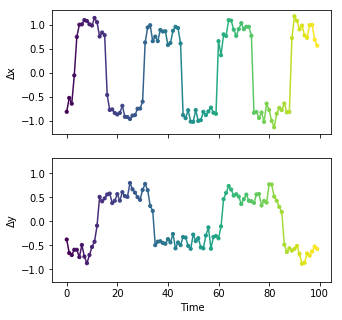

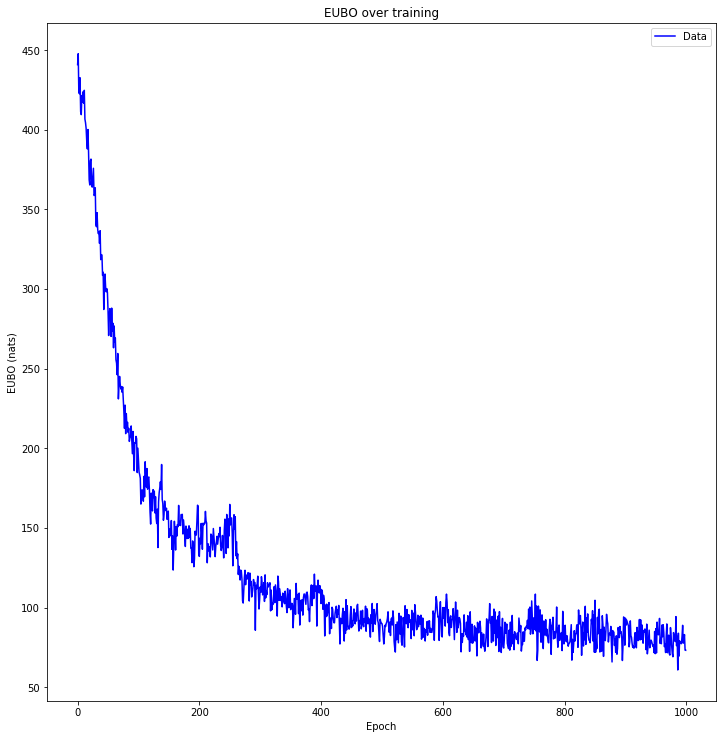

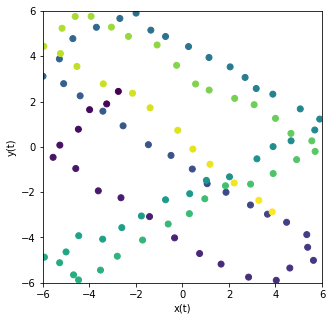

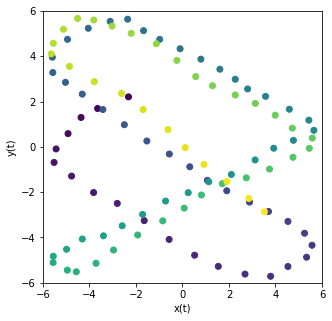

03/04/2019 00:18:30 MSE at time 0: tensor(0.2476)
03/04/2019 00:18:30 MSE at time 1: tensor(0.1935)
03/04/2019 00:18:30 MSE at time 2: tensor(0.2525)
03/04/2019 00:18:30 MSE at time 3: tensor(0.2347)
03/04/2019 00:18:30 MSE at time 4: tensor(0.0544)
03/04/2019 00:18:30 MSE at time 5: tensor(0.0531)
03/04/2019 00:18:30 MSE at time 6: tensor(0.1440)
03/04/2019 00:18:30 MSE at time 7: tensor(0.0468)
03/04/2019 00:18:30 MSE at time 8: tensor(0.0882)
03/04/2019 00:18:30 MSE at time 9: tensor(0.0840)
03/04/2019 00:18:30 MSE at time 10: tensor(0.0602)
03/04/2019 00:18:30 MSE at time 11: tensor(0.0510)
03/04/2019 00:18:30 MSE at time 12: tensor(0.0242)
03/04/2019 00:18:30 MSE at time 13: tensor(0.0416)
03/04/2019 00:18:30 MSE at time 14: tensor(0.0908)
03/04/2019 00:18:30 MSE at time 15: tensor(0.0110)
03/04/2019 00:18:30 MSE at time 16: tensor(0.1065)
03/04/2019 00:18:30 MSE at time 17: tensor(0.0431)
03/04/2019 00:18:30 MSE at time 18: tensor(0.0128)
03/04/2019 00:18:30 MSE at time 19: tenso

Epoch   647: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 00:23:03 ELBO=-1.39146301e+02 at epoch 649
03/04/2019 00:23:03 ELBO=-1.23442360e+02 at epoch 650
03/04/2019 00:23:04 ELBO=-1.37907242e+02 at epoch 651
03/04/2019 00:23:04 ELBO=-1.28492920e+02 at epoch 652
03/04/2019 00:23:05 ELBO=-1.23512787e+02 at epoch 653
03/04/2019 00:23:05 ELBO=-1.36295624e+02 at epoch 654
03/04/2019 00:23:05 ELBO=-1.18414436e+02 at epoch 655
03/04/2019 00:23:06 ELBO=-1.29086716e+02 at epoch 656
03/04/2019 00:23:06 ELBO=-1.19374847e+02 at epoch 657
03/04/2019 00:23:07 ELBO=-1.30812271e+02 at epoch 658
03/04/2019 00:23:07 ELBO=-1.33594513e+02 at epoch 659
03/04/2019 00:23:07 ELBO=-1.28003067e+02 at epoch 660
03/04/2019 00:23:08 ELBO=-1.13444153e+02 at epoch 661
03/04/2019 00:23:08 ELBO=-1.27319244e+02 at epoch 662
03/04/2019 00:23:09 ELBO=-1.40657486e+02 at epoch 663
03/04/2019 00:23:09 ELBO=-1.15447891e+02 at epoch 664
03/04/2019 00:23:10 ELBO=-1.21612091e+02 at epoch 665
03/04/2019 00:23:10 ELBO=-1.17353920e+02 at epoch 666
03/04/2019 00:23:10 ELBO=-1.

Epoch   843: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 00:24:24 ELBO=-1.26375809e+02 at epoch 845
03/04/2019 00:24:24 ELBO=-1.22924393e+02 at epoch 846
03/04/2019 00:24:24 ELBO=-1.17173973e+02 at epoch 847
03/04/2019 00:24:25 ELBO=-1.15759796e+02 at epoch 848
03/04/2019 00:24:25 ELBO=-1.38478241e+02 at epoch 849
03/04/2019 00:24:26 ELBO=-1.07909576e+02 at epoch 850
03/04/2019 00:24:26 ELBO=-9.44027786e+01 at epoch 851
03/04/2019 00:24:27 ELBO=-1.18949242e+02 at epoch 852
03/04/2019 00:24:27 ELBO=-1.01273705e+02 at epoch 853
03/04/2019 00:24:27 ELBO=-1.16361099e+02 at epoch 854
03/04/2019 00:24:28 ELBO=-1.12057281e+02 at epoch 855
03/04/2019 00:24:28 ELBO=-8.82665100e+01 at epoch 856
03/04/2019 00:24:29 ELBO=-1.23059944e+02 at epoch 857
03/04/2019 00:24:29 ELBO=-1.08423843e+02 at epoch 858
03/04/2019 00:24:29 ELBO=-1.01955864e+02 at epoch 859
03/04/2019 00:24:30 ELBO=-9.14176712e+01 at epoch 860
03/04/2019 00:24:30 ELBO=-9.71597061e+01 at epoch 861
03/04/2019 00:24:31 ELBO=-1.23352211e+02 at epoch 862
03/04/2019 00:24:31 ELBO=-9.

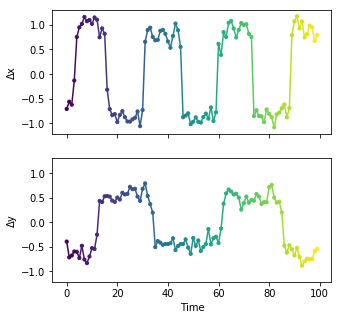

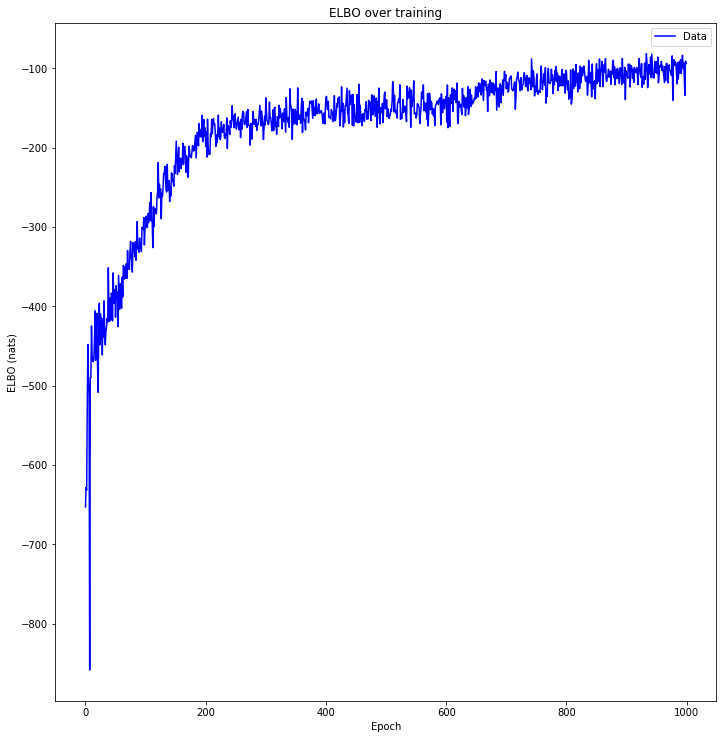

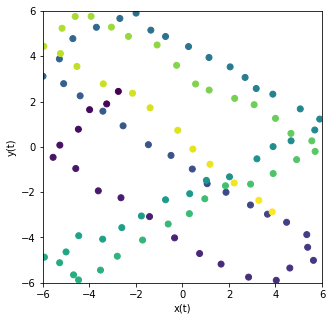

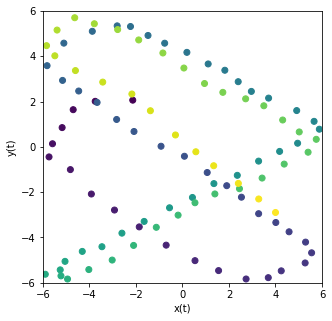

03/04/2019 00:25:28 MSE at time 0: tensor(0.5332)
03/04/2019 00:25:28 MSE at time 1: tensor(0.2565)
03/04/2019 00:25:28 MSE at time 2: tensor(0.4983)
03/04/2019 00:25:28 MSE at time 3: tensor(0.4930)
03/04/2019 00:25:28 MSE at time 4: tensor(0.1034)
03/04/2019 00:25:28 MSE at time 5: tensor(0.0309)
03/04/2019 00:25:28 MSE at time 6: tensor(0.0561)
03/04/2019 00:25:28 MSE at time 7: tensor(0.1091)
03/04/2019 00:25:28 MSE at time 8: tensor(0.3735)
03/04/2019 00:25:28 MSE at time 9: tensor(0.4022)
03/04/2019 00:25:28 MSE at time 10: tensor(0.2347)
03/04/2019 00:25:28 MSE at time 11: tensor(0.1376)
03/04/2019 00:25:28 MSE at time 12: tensor(0.0938)
03/04/2019 00:25:28 MSE at time 13: tensor(0.0183)
03/04/2019 00:25:28 MSE at time 14: tensor(0.1317)
03/04/2019 00:25:28 MSE at time 15: tensor(0.1511)
03/04/2019 00:25:28 MSE at time 16: tensor(0.1406)
03/04/2019 00:25:28 MSE at time 17: tensor(0.0886)
03/04/2019 00:25:28 MSE at time 18: tensor(0.1127)
03/04/2019 00:25:28 MSE at time 19: tenso

Epoch   481: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 00:28:58 ELBO=-1.49803284e+02 at epoch 483
03/04/2019 00:28:59 ELBO=-1.49202164e+02 at epoch 484
03/04/2019 00:28:59 ELBO=-1.46064133e+02 at epoch 485
03/04/2019 00:29:00 ELBO=-1.12363602e+02 at epoch 486
03/04/2019 00:29:00 ELBO=-1.35420654e+02 at epoch 487
03/04/2019 00:29:00 ELBO=-1.51085129e+02 at epoch 488
03/04/2019 00:29:01 ELBO=-1.36296371e+02 at epoch 489
03/04/2019 00:29:01 ELBO=-1.32343277e+02 at epoch 490
03/04/2019 00:29:02 ELBO=-1.35938492e+02 at epoch 491
03/04/2019 00:29:02 ELBO=-1.25108353e+02 at epoch 492
03/04/2019 00:29:03 ELBO=-1.33199539e+02 at epoch 493
03/04/2019 00:29:03 ELBO=-1.21650360e+02 at epoch 494
03/04/2019 00:29:04 ELBO=-1.08069969e+02 at epoch 495
03/04/2019 00:29:04 ELBO=-1.24406616e+02 at epoch 496
03/04/2019 00:29:04 ELBO=-1.15684975e+02 at epoch 497
03/04/2019 00:29:05 ELBO=-1.18247253e+02 at epoch 498
03/04/2019 00:29:05 ELBO=-1.12533318e+02 at epoch 499
03/04/2019 00:29:06 ELBO=-1.29760132e+02 at epoch 500
03/04/2019 00:29:06 ELBO=-1.

Epoch   656: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 00:30:13 ELBO=-1.21470490e+02 at epoch 658
03/04/2019 00:30:13 ELBO=-1.15895523e+02 at epoch 659
03/04/2019 00:30:13 ELBO=-1.14486427e+02 at epoch 660
03/04/2019 00:30:14 ELBO=-1.03367004e+02 at epoch 661
03/04/2019 00:30:14 ELBO=-1.03263817e+02 at epoch 662
03/04/2019 00:30:15 ELBO=-9.15205383e+01 at epoch 663
03/04/2019 00:30:15 ELBO=-9.76640091e+01 at epoch 664
03/04/2019 00:30:16 ELBO=-1.21341393e+02 at epoch 665
03/04/2019 00:30:16 ELBO=-1.13078949e+02 at epoch 666
03/04/2019 00:30:16 ELBO=-1.15188431e+02 at epoch 667
03/04/2019 00:30:17 ELBO=-1.10377304e+02 at epoch 668
03/04/2019 00:30:17 ELBO=-9.20752182e+01 at epoch 669
03/04/2019 00:30:18 ELBO=-1.01436478e+02 at epoch 670
03/04/2019 00:30:18 ELBO=-1.05213737e+02 at epoch 671
03/04/2019 00:30:18 ELBO=-9.63991852e+01 at epoch 672
03/04/2019 00:30:19 ELBO=-9.73413849e+01 at epoch 673
03/04/2019 00:30:19 ELBO=-1.12719055e+02 at epoch 674
03/04/2019 00:30:20 ELBO=-9.76238708e+01 at epoch 675
03/04/2019 00:30:20 ELBO=-8.

Epoch   858: reducing learning rate of group 0 to 1.2500e-02.


03/04/2019 00:31:39 ELBO=-8.89942551e+01 at epoch 860
03/04/2019 00:31:39 ELBO=-1.06105606e+02 at epoch 861
03/04/2019 00:31:40 ELBO=-1.09966301e+02 at epoch 862
03/04/2019 00:31:40 ELBO=-8.39451675e+01 at epoch 863
03/04/2019 00:31:41 ELBO=-1.05548271e+02 at epoch 864
03/04/2019 00:31:41 ELBO=-8.36086273e+01 at epoch 865
03/04/2019 00:31:41 ELBO=-1.14503700e+02 at epoch 866
03/04/2019 00:31:42 ELBO=-8.22970505e+01 at epoch 867
03/04/2019 00:31:42 ELBO=-9.52922821e+01 at epoch 868
03/04/2019 00:31:43 ELBO=-8.49027252e+01 at epoch 869
03/04/2019 00:31:43 ELBO=-8.38111801e+01 at epoch 870
03/04/2019 00:31:44 ELBO=-1.00583473e+02 at epoch 871
03/04/2019 00:31:44 ELBO=-8.96311417e+01 at epoch 872
03/04/2019 00:31:45 ELBO=-9.68000793e+01 at epoch 873
03/04/2019 00:31:45 ELBO=-8.66397858e+01 at epoch 874
03/04/2019 00:31:45 ELBO=-9.80987930e+01 at epoch 875
03/04/2019 00:31:46 ELBO=-9.28271103e+01 at epoch 876
03/04/2019 00:31:46 ELBO=-7.73832169e+01 at epoch 877
03/04/2019 00:31:47 ELBO=-8.

Epoch   959: reducing learning rate of group 0 to 6.2500e-03.


03/04/2019 00:32:22 ELBO=-9.74564896e+01 at epoch 961
03/04/2019 00:32:22 ELBO=-9.35859909e+01 at epoch 962
03/04/2019 00:32:23 ELBO=-8.81903458e+01 at epoch 963
03/04/2019 00:32:23 ELBO=-8.13583908e+01 at epoch 964
03/04/2019 00:32:24 ELBO=-8.48267059e+01 at epoch 965
03/04/2019 00:32:24 ELBO=-1.01398796e+02 at epoch 966
03/04/2019 00:32:24 ELBO=-8.24684296e+01 at epoch 967
03/04/2019 00:32:25 ELBO=-8.68322830e+01 at epoch 968
03/04/2019 00:32:25 ELBO=-7.47639999e+01 at epoch 969
03/04/2019 00:32:26 ELBO=-8.34276428e+01 at epoch 970
03/04/2019 00:32:26 ELBO=-9.98458939e+01 at epoch 971
03/04/2019 00:32:26 ELBO=-8.28133850e+01 at epoch 972
03/04/2019 00:32:27 ELBO=-7.16211166e+01 at epoch 973
03/04/2019 00:32:27 ELBO=-8.68207932e+01 at epoch 974
03/04/2019 00:32:28 ELBO=-1.00185432e+02 at epoch 975
03/04/2019 00:32:28 ELBO=-8.53511963e+01 at epoch 976
03/04/2019 00:32:29 ELBO=-8.84143524e+01 at epoch 977
03/04/2019 00:32:29 ELBO=-8.36381836e+01 at epoch 978
03/04/2019 00:32:30 ELBO=-8.

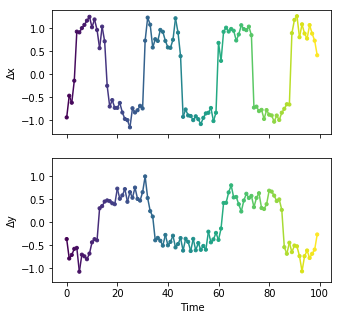

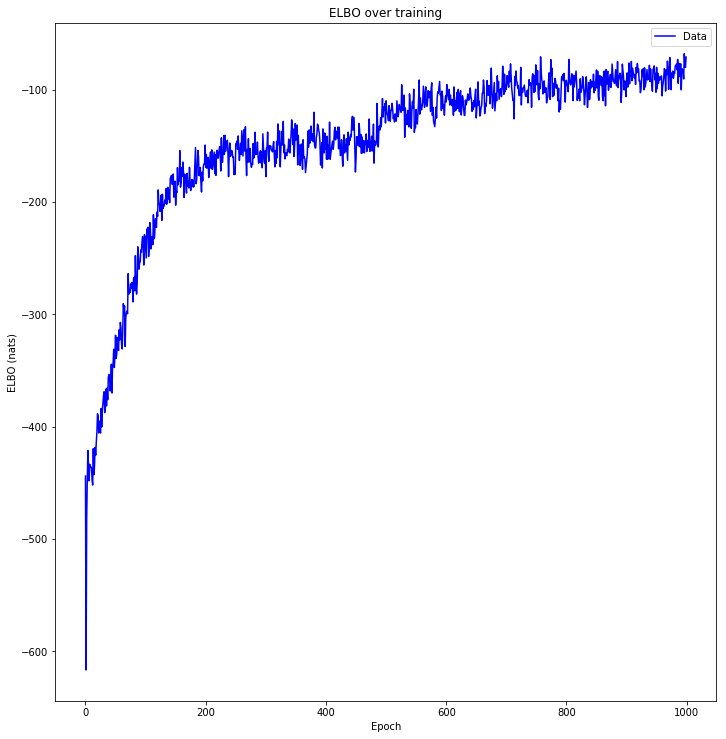

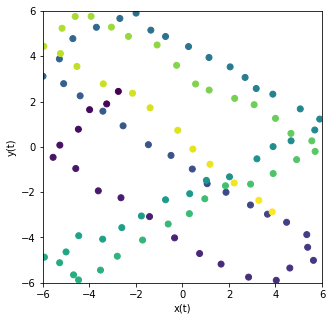

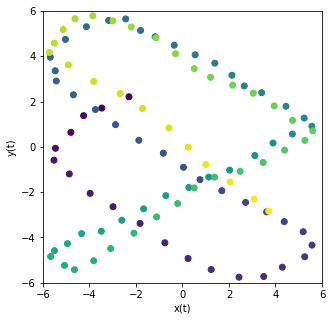

03/04/2019 00:32:40 MSE at time 0: tensor(0.2656)
03/04/2019 00:32:40 MSE at time 1: tensor(0.0773)
03/04/2019 00:32:40 MSE at time 2: tensor(0.1359)
03/04/2019 00:32:40 MSE at time 3: tensor(0.1228)
03/04/2019 00:32:40 MSE at time 4: tensor(0.0547)
03/04/2019 00:32:40 MSE at time 5: tensor(0.0175)
03/04/2019 00:32:40 MSE at time 6: tensor(0.1353)
03/04/2019 00:32:40 MSE at time 7: tensor(0.1352)
03/04/2019 00:32:40 MSE at time 8: tensor(0.2745)
03/04/2019 00:32:40 MSE at time 9: tensor(0.2568)
03/04/2019 00:32:40 MSE at time 10: tensor(0.2214)
03/04/2019 00:32:40 MSE at time 11: tensor(0.2935)
03/04/2019 00:32:40 MSE at time 12: tensor(0.2395)
03/04/2019 00:32:40 MSE at time 13: tensor(0.1706)
03/04/2019 00:32:40 MSE at time 14: tensor(0.3201)
03/04/2019 00:32:40 MSE at time 15: tensor(0.1045)
03/04/2019 00:32:40 MSE at time 16: tensor(0.1639)
03/04/2019 00:32:40 MSE at time 17: tensor(0.0441)
03/04/2019 00:32:40 MSE at time 18: tensor(0.0401)
03/04/2019 00:32:40 MSE at time 19: tenso

Epoch   501: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 00:36:40 ELBO=-1.46352753e+02 at epoch 503
03/04/2019 00:36:40 ELBO=-1.42329010e+02 at epoch 504
03/04/2019 00:36:41 ELBO=-1.40730347e+02 at epoch 505
03/04/2019 00:36:41 ELBO=-1.38134186e+02 at epoch 506
03/04/2019 00:36:42 ELBO=-1.35642532e+02 at epoch 507
03/04/2019 00:36:42 ELBO=-1.16260384e+02 at epoch 508
03/04/2019 00:36:43 ELBO=-1.27782745e+02 at epoch 509
03/04/2019 00:36:43 ELBO=-1.30212219e+02 at epoch 510
03/04/2019 00:36:44 ELBO=-1.25286942e+02 at epoch 511
03/04/2019 00:36:44 ELBO=-1.07102295e+02 at epoch 512
03/04/2019 00:36:45 ELBO=-1.15191460e+02 at epoch 513
03/04/2019 00:36:45 ELBO=-1.16369064e+02 at epoch 514
03/04/2019 00:36:46 ELBO=-1.17625473e+02 at epoch 515
03/04/2019 00:36:46 ELBO=-1.25744652e+02 at epoch 516
03/04/2019 00:36:47 ELBO=-1.20817329e+02 at epoch 517
03/04/2019 00:36:47 ELBO=-1.25283730e+02 at epoch 518
03/04/2019 00:36:47 ELBO=-1.19009949e+02 at epoch 519
03/04/2019 00:36:48 ELBO=-1.14399864e+02 at epoch 520
03/04/2019 00:36:48 ELBO=-1.

Epoch   768: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 00:38:44 ELBO=-1.11166374e+02 at epoch 770
03/04/2019 00:38:45 ELBO=-1.22799110e+02 at epoch 771
03/04/2019 00:38:45 ELBO=-1.07344215e+02 at epoch 772
03/04/2019 00:38:46 ELBO=-1.27002182e+02 at epoch 773
03/04/2019 00:38:46 ELBO=-1.14509605e+02 at epoch 774
03/04/2019 00:38:46 ELBO=-1.13237968e+02 at epoch 775
03/04/2019 00:38:47 ELBO=-1.02301613e+02 at epoch 776
03/04/2019 00:38:47 ELBO=-1.13944176e+02 at epoch 777
03/04/2019 00:38:48 ELBO=-1.06832893e+02 at epoch 778
03/04/2019 00:38:48 ELBO=-1.03921356e+02 at epoch 779
03/04/2019 00:38:49 ELBO=-1.05079361e+02 at epoch 780
03/04/2019 00:38:49 ELBO=-8.90133209e+01 at epoch 781
03/04/2019 00:38:50 ELBO=-8.21079559e+01 at epoch 782
03/04/2019 00:38:50 ELBO=-8.61602478e+01 at epoch 783
03/04/2019 00:38:51 ELBO=-8.64635620e+01 at epoch 784
03/04/2019 00:38:51 ELBO=-1.04176956e+02 at epoch 785
03/04/2019 00:38:52 ELBO=-7.68200378e+01 at epoch 786
03/04/2019 00:38:52 ELBO=-9.49289780e+01 at epoch 787
03/04/2019 00:38:53 ELBO=-8.

Epoch   886: reducing learning rate of group 0 to 1.2500e-02.


03/04/2019 00:39:40 ELBO=-9.60967636e+01 at epoch 888
03/04/2019 00:39:40 ELBO=-9.82637253e+01 at epoch 889
03/04/2019 00:39:40 ELBO=-8.95595856e+01 at epoch 890
03/04/2019 00:39:41 ELBO=-8.88709183e+01 at epoch 891
03/04/2019 00:39:41 ELBO=-9.39071121e+01 at epoch 892
03/04/2019 00:39:42 ELBO=-9.33667374e+01 at epoch 893
03/04/2019 00:39:42 ELBO=-7.76621857e+01 at epoch 894
03/04/2019 00:39:43 ELBO=-9.15334473e+01 at epoch 895
03/04/2019 00:39:43 ELBO=-8.06543350e+01 at epoch 896
03/04/2019 00:39:44 ELBO=-8.28985748e+01 at epoch 897
03/04/2019 00:39:44 ELBO=-9.71534500e+01 at epoch 898
03/04/2019 00:39:45 ELBO=-1.02704887e+02 at epoch 899
03/04/2019 00:39:45 ELBO=-9.67013321e+01 at epoch 900
03/04/2019 00:39:46 ELBO=-8.33779068e+01 at epoch 901
03/04/2019 00:39:46 ELBO=-8.77748413e+01 at epoch 902
03/04/2019 00:39:47 ELBO=-8.93677521e+01 at epoch 903
03/04/2019 00:39:47 ELBO=-8.12003098e+01 at epoch 904
03/04/2019 00:39:48 ELBO=-9.32029114e+01 at epoch 905
03/04/2019 00:39:48 ELBO=-8.

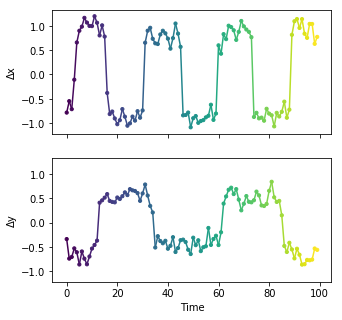

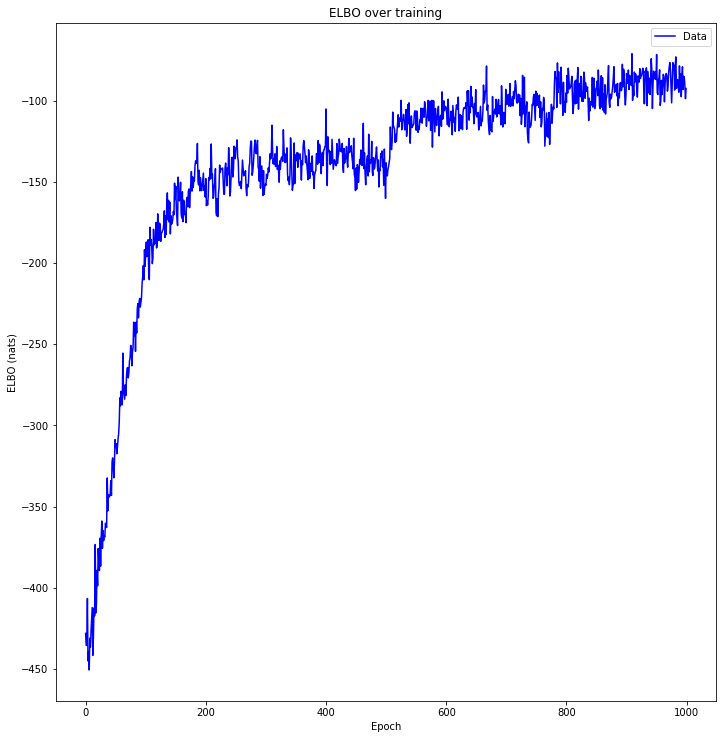

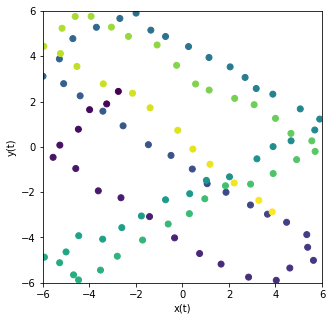

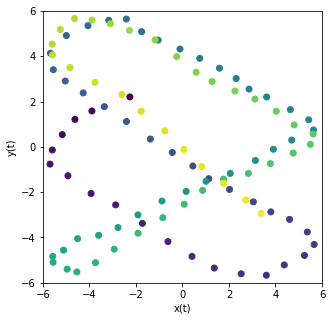

03/04/2019 00:40:42 MSE at time 0: tensor(0.3061)
03/04/2019 00:40:42 MSE at time 1: tensor(0.5007)
03/04/2019 00:40:42 MSE at time 2: tensor(0.5785)
03/04/2019 00:40:42 MSE at time 3: tensor(0.5364)
03/04/2019 00:40:42 MSE at time 4: tensor(0.1510)
03/04/2019 00:40:42 MSE at time 5: tensor(0.1066)
03/04/2019 00:40:42 MSE at time 6: tensor(0.2153)
03/04/2019 00:40:42 MSE at time 7: tensor(0.1108)
03/04/2019 00:40:42 MSE at time 8: tensor(0.1524)
03/04/2019 00:40:42 MSE at time 9: tensor(0.1826)
03/04/2019 00:40:42 MSE at time 10: tensor(0.1090)
03/04/2019 00:40:42 MSE at time 11: tensor(0.1215)
03/04/2019 00:40:42 MSE at time 12: tensor(0.1161)
03/04/2019 00:40:42 MSE at time 13: tensor(0.1224)
03/04/2019 00:40:42 MSE at time 14: tensor(0.2322)
03/04/2019 00:40:42 MSE at time 15: tensor(0.0750)
03/04/2019 00:40:42 MSE at time 16: tensor(0.1964)
03/04/2019 00:40:42 MSE at time 17: tensor(0.0932)
03/04/2019 00:40:42 MSE at time 18: tensor(0.0137)
03/04/2019 00:40:42 MSE at time 19: tenso

In [ ]:
results_dict = experiment()

In [ ]:
torch.save(results_dict, 'examples/dynamical_ball/experiment_results.data')